# Liquid neural networks for PV power forecasting

In [ ]:
# # trading code.
# def Trading_const(npy):
#     for i in range(len(npy)):
#         if npy[i]>1800:
#             npy[i] = 1800
#         elif npy[i]<0:
#             npy[i] = 0
#         else:
#             pass
#     return npy


# Actual_prediction_oneday = pd.read_csv(dataPath + f"hybrid_energy_result_{test_date[2:4]+test_date[5:7]+test_date[8:10]}.csv").iloc[:,2:].to_numpy()
# Trading_actual_pred_avg_oneday = Trading_const(Actual_prediction_oneday.mean(axis=1).reshape(-1))
# np.save(resultPath + f'trading_final_{test_date[2:4]+test_date[5:7]+test_date[8:10]}.npy',Trading_actual_pred_avg_oneday)

In [1]:
import pandas as pd
import xarray as xr
import numpy as np

import random
import os
# import comp_utils

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import pickle as pkl

## additional lib.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

from sam import SAM
# import GSAM class and scheduler
from gsam import GSAM, LinearScheduler

# from ncps.wirings import AutoNCP 
from ncps.torch import LTC

from RevIN import RevIN

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)



def read_weahter_nc_to_df(file_name, type="wind"):
    
    if type == "wind":
        ### DWD : Hornsea 1 (풍력 발전소) 관련 날씨 예보
        df = xr.open_dataset(file_name)
        
        # 6개의 feature 모두 활용하기 위함
        df = df[['RelativeHumidity', 'Temperature', 'WindDirection', 
                 'WindDirection:100', 'WindSpeed', 'WindSpeed:100']].mean(dim=["latitude", "longitude"]).to_dataframe().reset_index()
        
        df["ref_datetime"] = df["ref_datetime"].dt.tz_localize("UTC")
        df["valid_datetime"] = df["ref_datetime"] + pd.TimedeltaIndex(df["valid_datetime"], unit="hours")
        df.rename(columns={"Temperature":"Temperature_wind"}, inplace=True)

        return df
    
    if type == "solar":
        ### DWD : PES 10 (태양광 발전소) 관련 날씨 예보
        df = xr.open_dataset(file_name)
        
        # 3개의 feature 모두 활용하기 위함
        df = df[['CloudCover', 'SolarDownwardRadiation', 'Temperature']].mean(dim="point").to_dataframe().reset_index()
        
        df["ref_datetime"] = df["ref_datetime"].dt.tz_localize("UTC")
        df["valid_datetime"] = df["ref_datetime"] + pd.TimedeltaIndex(df["valid_datetime"],unit="hours")
        df.rename(columns={"Temperature":"Temperature_solar"}, inplace=True)
        
        return df


def read_weahter_nc_to_df2(file_name, type="wind"):
    
    if type == "wind":
        ### DWD : Hornsea 1 (풍력 발전소) 관련 날씨 예보
        df = xr.open_dataset(file_name)
        
        # 6개의 feature 모두 활용하기 위함
        df = df[['RelativeHumidity', 'Temperature', 'WindDirection', 
                 'WindDirection:100', 'WindSpeed', 'WindSpeed:100']].mean(dim=["latitude", "longitude"]).to_dataframe().reset_index()
        
        df["reference_time"] = df["reference_time"].dt.tz_localize("UTC")
        df["valid_time"] = df["reference_time"] + pd.TimedeltaIndex(df["valid_time"], unit="hours")
        df.rename(columns={"Temperature":"Temperature_wind"}, inplace=True)

        return df
    
    if type == "solar":
        ### DWD : PES 10 (태양광 발전소) 관련 날씨 예보
        df = xr.open_dataset(file_name)
        
        # 3개의 feature 모두 활용하기 위함
        df = df[['CloudCover', 'SolarDownwardRadiation', 'Temperature']].mean(dim="point").to_dataframe().reset_index()
        
        df["reference_time"] = df["reference_time"].dt.tz_localize("UTC")
        df["valid_time"] = df["reference_time"] + pd.TimedeltaIndex(df["valid_time"],unit="hours")
        df.rename(columns={"Temperature":"Temperature_solar"}, inplace=True)
    
        return df


def read_energy_nc_to_df(file_name):
    
    ### DWD : Hornsea 1 (풍력 발전소) 관련 날씨 예보
    energy_data = pd.read_csv(file_name)
    energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
    energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
    energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]
    energy_data.head()
        
    return energy_data


def merge_weather_and_energy(df_wind, df_solar, df_energy):
# def merge_weather_and_energy(df_wind, df_energy):
    
    ## Merge Energy and Weather Data
    modelling_table = df_wind.merge(df_solar, how="outer", on=["ref_datetime", "valid_datetime"])
    # modelling_table = df_wind.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
    modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
    modelling_table = modelling_table.drop(columns="ref_datetime", axis=1).reset_index()
    
    modelling_table = modelling_table.merge(df_energy, how="inner", 
                                            left_on="valid_datetime", 
                                            right_on="dtm")
    
    modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50, "h")]

    return modelling_table


def data_preprocess(modelling_table):
    # total_range = pd.date_range(start="2020-09-20", end="2023-10-27").strftime("%Y-%m-%d").to_list()
    total_range = pd.date_range(start="2020-09-20", end="2024-01-01").strftime("%Y-%m-%d").to_list()

    total_range_00 = pd.date_range(start="2020-09-20", end="2024-01-18").strftime("%Y-%m-%d").to_list()
    total_range_06 = pd.date_range(start="2020-09-20", end="2024-01-18").strftime("%Y-%m-%d").to_list()
    total_range_12 = pd.date_range(start="2020-09-20", end="2024-01-18").strftime("%Y-%m-%d").to_list()
    total_range_18 = pd.date_range(start="2020-09-20", end="2024-01-18").strftime("%Y-%m-%d").to_list()

    target_date = pd.date_range(start="2020-09-20", end="2024-01-18").strftime("%Y-%m-%d").to_list()

    # 00:00:00에 발표된 데이터만 활용
    for i in range(len(total_range)):
        total_range_00[i] += " 00:00:00"

    # 06:00:00에 발표된 데이터만 활용    
    for i in range(len(total_range)):
        total_range_06[i] += " 06:00:00"
        
    # 12:00:00에 발표된 데이터만 활용    
    for i in range(len(total_range)):
        total_range_12[i] += " 12:00:00"
        
    # 18:00:00에 발표된 데이터만 활용    
    for i in range(len(total_range)):
        total_range_18[i] += " 18:00:00"

    train_final_df = pd.DataFrame()

    columns = ['valid_datetime', 'ref_datetime', 
            #'RelativeHumidity', 'Temperature_wind', 'WindDirection', 'WindDirection:100', 'WindSpeed', 'WindSpeed:100', 
            'CloudCover', 'SolarDownwardRadiation', 'Temperature_solar', 'Solar_MWh_credit',
            #'Solar_MW', 'Solar_capacity_mwp', 'Solar_installedcapacity_mwp', 'Solar_MWh_credit',
            #'Wind_MW', 'Wind_MWh_credit', 'pressure'
            ]

    for ref_time_00_idx, ref_time_06_idx, ref_time_12_idx, ref_time_18_idx in zip(total_range_00, total_range_06, total_range_12, total_range_18):
        
        # print(ref_time_00_idx, ref_time_06_idx, ref_time_12_idx, ref_time_18_idx)
        # "(day) 00:00:00" ~ "(day) 05:30:00" 에 해당되는 input 및 target data
        temp_ref_datetime = pd.to_datetime(ref_time_00_idx)
        year, month, day = temp_ref_datetime.year, temp_ref_datetime.month, temp_ref_datetime.day
        
        start_time = pd.to_datetime(f"{year}-{month}-{day} 00:00:00")
        end_time = pd.to_datetime(f"{year}-{month}-{day} 05:30:00")
        
        print(f"Intervals : {start_time} ~ {end_time}")
        temp_df_00 = modelling_table[modelling_table['ref_datetime'] == ref_time_00_idx].set_index('valid_datetime')[str(start_time):str(end_time)].reset_index()
        temp_df_00 = temp_df_00[columns]
        
        # "(day) 06:00:00" ~ "(day) 11:30:00" 에 해당되는 input 및 target data
        temp_ref_datetime = pd.to_datetime(ref_time_06_idx)
        year, month, day = temp_ref_datetime.year, temp_ref_datetime.month, temp_ref_datetime.day
        
        start_time = pd.to_datetime(f"{year}-{month}-{day} 06:00:00")
        end_time = pd.to_datetime(f"{year}-{month}-{day} 11:30:00")
        
        print(f"Intervals : {start_time} ~ {end_time}")
        temp_df_06 = modelling_table[modelling_table['ref_datetime'] == ref_time_06_idx].set_index('valid_datetime')[str(start_time):str(end_time)].reset_index()
        temp_df_06 = temp_df_06[columns]
        
        # "(day) 12:00:00" ~ "(day) 17:30:00" 에 해당되는 input 및 target data
        temp_ref_datetime = pd.to_datetime(ref_time_12_idx)
        year, month, day = temp_ref_datetime.year, temp_ref_datetime.month, temp_ref_datetime.day
        
        start_time = pd.to_datetime(f"{year}-{month}-{day} 12:00:00")
        end_time = pd.to_datetime(f"{year}-{month}-{day} 17:30:00")
        
        print(f"Intervals : {start_time} ~ {end_time}")
        temp_df_12 = modelling_table[modelling_table['ref_datetime'] == ref_time_12_idx].set_index('valid_datetime')[str(start_time):str(end_time)].reset_index()
        temp_df_12 = temp_df_12[columns]
        
        # "(day) 18:00:00" ~ "(day) 23:30:00" 에 해당되는 input 및 target data    
        temp_ref_datetime = pd.to_datetime(ref_time_18_idx)
        year, month, day = temp_ref_datetime.year, temp_ref_datetime.month, temp_ref_datetime.day
        
        start_time = pd.to_datetime(f"{year}-{month}-{day} 18:00:00")
        end_time = pd.to_datetime(f"{year}-{month}-{day} 23:30:00")
        
        print(f"Intervals : {start_time} ~ {end_time}")
        temp_df_18 = modelling_table[modelling_table['ref_datetime'] == ref_time_18_idx].set_index('valid_datetime')[str(start_time):str(end_time)].reset_index()
        temp_df_18 = temp_df_18[columns]
        
        temp_df = pd.concat([temp_df_00, temp_df_06, temp_df_12, temp_df_18], axis=0)
        
        # 수집 데이터에 결측치가 존재하거나 48개가 아니라면 사용 X (데이터 품질을 위함)
        if sum(np.sum(temp_df.isna())) == 0 and len(temp_df) == 48:
            train_final_df = pd.concat([train_final_df, temp_df], axis=0)
        else:
            #print(f"Missing Value Exists : {red_datetime_idx}, Length : {len(temp_df)}")
            print(f"{year}-{month}-{day} : {np.sum(temp_df.isna())}")
            #nan_date.append(red_datetime_idx)
    
    # for i in range(len(total_range)):
    #     total_range[i] += " 00:00:00"

    # re_modelling_table = pd.DataFrame()
    # for i in range(len(total_range)):
    #     sliced_proper_df = modelling_table[modelling_table['ref_datetime'] == total_range[i]].iloc[:48,:]
    #     if (sliced_proper_df.shape[0] < 48) or (sliced_proper_df["valid_datetime"].iloc[0].day != sliced_proper_df["valid_datetime"].iloc[-1].day):
    #         # print(total_range[i]) # missing dates 출력.
    #         reconfig_date = total_range[i-1][:10] + " 18:00:00"
    #         reconfig_modelling_table = modelling_table[modelling_table['ref_datetime'] == reconfig_date].iloc[12:12+48,:]
            
    #         if (reconfig_modelling_table.shape[0] < 48) or (reconfig_modelling_table["valid_datetime"].iloc[0].day != reconfig_modelling_table["valid_datetime"].iloc[-1].day):
    #             reconfig_date = total_range[i-1][:10] + " 12:00:00" # set again to the previous forecast initial time.
    #             reconfig_modelling_table = modelling_table[modelling_table['ref_datetime'] == reconfig_date].iloc[12+12:12+12+48,:]
                
    #             if (reconfig_modelling_table.shape[0] < 48) or (reconfig_modelling_table["valid_datetime"].iloc[0].day != reconfig_modelling_table["valid_datetime"].iloc[-1].day):
    #                 # print(reconfig_date)
    #                 reconfig_date = total_range[i-1][:10] + " 06:00:00" # set again to the previous forecast initial time.
    #                 reconfig_modelling_table = modelling_table[modelling_table['ref_datetime'] == reconfig_date].iloc[12+12+12:12+12+12+48,:]
                    
    #                 if (reconfig_modelling_table.shape[0] < 48) or (reconfig_modelling_table["valid_datetime"].iloc[0].day != reconfig_modelling_table["valid_datetime"].iloc[-1].day):
    #                     reconfig_date = total_range[i-1][:10] + " 00:00:00" # set again to the previous forecast initial time.
    #                     reconfig_modelling_table = modelling_table[modelling_table['ref_datetime'] == reconfig_date].iloc[48:48+48,:]

    #                     if (reconfig_modelling_table.shape[0] < 48) or (reconfig_modelling_table["valid_datetime"].iloc[0].day != reconfig_modelling_table["valid_datetime"].iloc[-1].day):
    #                         print(total_range[i]) # missing dates 출력. <= 연쇄적으로 missing이어서 구할 수 없는 구간..
    #                         reconfig_modelling_table = None

    #         re_modelling_table = pd.concat([re_modelling_table, reconfig_modelling_table], axis=0)
    #     else:
    #         re_modelling_table = pd.concat([re_modelling_table, sliced_proper_df], axis=0)

    # return re_modelling_table
    return train_final_df

In [3]:
# DWD 모델 사용
df_wind_ = read_weahter_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\dwd_icon_eu_hornsea_1_20200920_20231027.nc", type="wind")
df_solar_ = read_weahter_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\dwd_icon_eu_pes10_20200920_20231027.nc", type="solar")
df_wind_ = df_wind_[df_wind_['ref_datetime'] < '2023-10-27']
df_solar_ = df_solar_[df_solar_['ref_datetime'] < '2023-10-27']

df_wind__ = read_weahter_nc_to_df2(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\dwd_icon_eu_hornsea_1_20231027_20240108.nc", type="wind")
df_solar__ = read_weahter_nc_to_df2(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\dwd_icon_eu_pes10_20231027_20240108.nc", type="solar")
df_wind__ = df_wind__[df_wind__['valid_time'] < '2024-01-01']
df_solar__ = df_solar__[df_solar__['valid_time'] < '2024-01-01']

energy_data = read_energy_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\Energy_Data_20200920_20240118.csv")
energy_data = energy_data[energy_data['dtm'] < '2024-01-01']


df_wind__.columns = df_wind_.columns
df_solar__.columns = df_solar_.columns

df_wind = pd.concat([df_wind_,df_wind__], axis=0)
df_solar = pd.concat([df_solar_,df_solar__], axis=0)

# modeling_table 1차
modeling_table = merge_weather_and_energy(df_wind, df_solar, energy_data)
# modeling_table = merge_weather_and_energy(df_wind, energy_data)


# re_modeling_table input/target 관계에 대한 noise 제거
# modeling_table = modeling_table[~((modeling_table["WindSpeed:100"] >= 20) & (modeling_table["Wind_MWh_credit"] <= 270))] # threshold windspeed100 (20, 200)

# additional output nan remove!!
modeling_table = modeling_table[~(modeling_table["Solar_MWh_credit"].isna())]


modeling_table = modeling_table[~((modeling_table["SolarDownwardRadiation"] >= 50) & (modeling_table["SolarDownwardRadiation"] <= 100) 
                                & (modeling_table["Solar_MWh_credit"] >= 500))] # threshold 
modeling_table = modeling_table[~((modeling_table["SolarDownwardRadiation"] <= 30) 
                                & (modeling_table["Solar_MWh_credit"] >= 150))] # threshold 
modeling_table = modeling_table[~((modeling_table["SolarDownwardRadiation"] > 100) & (modeling_table["SolarDownwardRadiation"] <= 270) 
                                & (modeling_table["Solar_MWh_credit"] <= 10))] # threshold 


# re_modeling_table
re_modelling_table = data_preprocess(modeling_table)
# re_modelling_table = modeling_table

# additional noise removal!!
re_modelling_table = re_modelling_table[~((re_modelling_table["CloudCover"] >= 0.1) & (re_modelling_table["CloudCover"] <= 0.35) 
                                          & (re_modelling_table["SolarDownwardRadiation"] >= 150) & (re_modelling_table["SolarDownwardRadiation"] <= 250) &
                                          (re_modelling_table["Solar_MWh_credit"] <= 40))]

#################### 선택 필요 ####################  
# re_modelling_table.interpolate('linear', inplace=True)
# re_modelling_table = re_modelling_table.dropna()
################################################### 

# re_modeling_table input/target 관계에 대한 noise 제거
# re_modelling_table = re_modelling_table[~((re_modelling_table["WindSpeed:100"] >= 20) & (re_modelling_table["Wind_MWh_credit"] <= 270))] # threshold windspeed100 (20, 200)

print(f"{len(re_modelling_table)}")

Intervals : 2020-09-20 00:00:00 ~ 2020-09-20 05:30:00
Intervals : 2020-09-20 06:00:00 ~ 2020-09-20 11:30:00
Intervals : 2020-09-20 12:00:00 ~ 2020-09-20 17:30:00
Intervals : 2020-09-20 18:00:00 ~ 2020-09-20 23:30:00
Intervals : 2020-09-21 00:00:00 ~ 2020-09-21 05:30:00
Intervals : 2020-09-21 06:00:00 ~ 2020-09-21 11:30:00
Intervals : 2020-09-21 12:00:00 ~ 2020-09-21 17:30:00
Intervals : 2020-09-21 18:00:00 ~ 2020-09-21 23:30:00
Intervals : 2020-09-22 00:00:00 ~ 2020-09-22 05:30:00
Intervals : 2020-09-22 06:00:00 ~ 2020-09-22 11:30:00
Intervals : 2020-09-22 12:00:00 ~ 2020-09-22 17:30:00
Intervals : 2020-09-22 18:00:00 ~ 2020-09-22 23:30:00
Intervals : 2020-09-23 00:00:00 ~ 2020-09-23 05:30:00
Intervals : 2020-09-23 06:00:00 ~ 2020-09-23 11:30:00
Intervals : 2020-09-23 12:00:00 ~ 2020-09-23 17:30:00
Intervals : 2020-09-23 18:00:00 ~ 2020-09-23 23:30:00
Intervals : 2020-09-24 00:00:00 ~ 2020-09-24 05:30:00
Intervals : 2020-09-24 06:00:00 ~ 2020-09-24 11:30:00
Intervals : 2020-09-24 12:00

In [4]:
# NCEP 모델 사용
df_wind_ = read_weahter_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\ncep_gfs_hornsea_1_20200920_20231027.nc", type="wind")
df_solar_ = read_weahter_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\ncep_gfs_pes10_20200920_20231027.nc", type="solar")
df_wind_ = df_wind_[df_wind_['ref_datetime'] < '2023-10-27']
df_solar_ = df_solar_[df_solar_['ref_datetime'] < '2023-10-27']

df_wind__ = read_weahter_nc_to_df2(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\ncep_gfs_hornsea_1_20231027_20240108.nc", type="wind")
df_solar__ = read_weahter_nc_to_df2(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\ncep_gfs_pes10_20231027_20240108.nc", type="solar")
df_wind__ = df_wind__[df_wind__['valid_time'] < '2024-01-01']
df_solar__ = df_solar__[df_solar__['valid_time'] < '2024-01-01']

energy_data = read_energy_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\Energy_Data_20200920_20240118.csv")
energy_data = energy_data[energy_data['dtm'] < '2024-01-01']

df_wind__.columns = df_wind_.columns
df_solar__.columns = df_solar_.columns

df_wind = pd.concat([df_wind_,df_wind__], axis=0)
df_solar = pd.concat([df_solar_,df_solar__], axis=0)

# modeling_table 1차
modeling_table_ncep = merge_weather_and_energy(df_wind, df_solar, energy_data)
# modeling_table = merge_weather_and_energy(df_wind, energy_data)


# re_modeling_table input/target 관계에 대한 noise 제거
# modeling_table = modeling_table[~((modeling_table["WindSpeed:100"] >= 20) & (modeling_table["Wind_MWh_credit"] <= 270))] # threshold windspeed100 (20, 200)

# additional output nan remove!!
modeling_table_ncep = modeling_table_ncep[~(modeling_table_ncep["Solar_MWh_credit"].isna())]


modeling_table_ncep = modeling_table_ncep[~((modeling_table_ncep["SolarDownwardRadiation"] >= 50) & (modeling_table_ncep["SolarDownwardRadiation"] <= 100) 
                                & (modeling_table_ncep["Solar_MWh_credit"] >= 500))] # threshold 
modeling_table_ncep = modeling_table_ncep[~((modeling_table_ncep["SolarDownwardRadiation"] <= 30) 
                                & (modeling_table_ncep["Solar_MWh_credit"] >= 150))] # threshold 
modeling_table_ncep = modeling_table_ncep[~((modeling_table_ncep["SolarDownwardRadiation"] > 100) & (modeling_table_ncep["SolarDownwardRadiation"] <= 270) 
                                & (modeling_table_ncep["Solar_MWh_credit"] <= 10))] # threshold 


# re_modeling_table
re_modelling_table_ncep = data_preprocess(modeling_table_ncep)
# re_modelling_table = modeling_table

# additional noise removal!!
re_modelling_table_ncep = re_modelling_table_ncep[~((re_modelling_table_ncep["CloudCover"] >= 0.1) & (re_modelling_table_ncep["CloudCover"] <= 0.35) 
                                          & (re_modelling_table_ncep["SolarDownwardRadiation"] >= 150) & (re_modelling_table_ncep["SolarDownwardRadiation"] <= 250) &
                                          (re_modelling_table_ncep["Solar_MWh_credit"] <= 40))]

#################### 선택 필요 ####################  
# re_modelling_table.interpolate('linear', inplace=True)
# re_modelling_table = re_modelling_table.dropna()
################################################### 

# re_modeling_table input/target 관계에 대한 noise 제거
# re_modelling_table = re_modelling_table[~((re_modelling_table["WindSpeed:100"] >= 20) & (re_modelling_table["Wind_MWh_credit"] <= 270))] # threshold windspeed100 (20, 200)

print(f"{len(re_modelling_table_ncep)}")

Intervals : 2020-09-20 00:00:00 ~ 2020-09-20 05:30:00
Intervals : 2020-09-20 06:00:00 ~ 2020-09-20 11:30:00
Intervals : 2020-09-20 12:00:00 ~ 2020-09-20 17:30:00
Intervals : 2020-09-20 18:00:00 ~ 2020-09-20 23:30:00
Intervals : 2020-09-21 00:00:00 ~ 2020-09-21 05:30:00
Intervals : 2020-09-21 06:00:00 ~ 2020-09-21 11:30:00
Intervals : 2020-09-21 12:00:00 ~ 2020-09-21 17:30:00
Intervals : 2020-09-21 18:00:00 ~ 2020-09-21 23:30:00
Intervals : 2020-09-22 00:00:00 ~ 2020-09-22 05:30:00
Intervals : 2020-09-22 06:00:00 ~ 2020-09-22 11:30:00
Intervals : 2020-09-22 12:00:00 ~ 2020-09-22 17:30:00
Intervals : 2020-09-22 18:00:00 ~ 2020-09-22 23:30:00
Intervals : 2020-09-23 00:00:00 ~ 2020-09-23 05:30:00
Intervals : 2020-09-23 06:00:00 ~ 2020-09-23 11:30:00
Intervals : 2020-09-23 12:00:00 ~ 2020-09-23 17:30:00
Intervals : 2020-09-23 18:00:00 ~ 2020-09-23 23:30:00
Intervals : 2020-09-24 00:00:00 ~ 2020-09-24 05:30:00
Intervals : 2020-09-24 06:00:00 ~ 2020-09-24 11:30:00
Intervals : 2020-09-24 12:00

In [ ]:
# feature engineering for wind forecsting

import math
from datetime import timedelta


def air_density(pressure, temperature, relative_humidity):
    """
    Calculate air density in kg/m^3 given pressure in Pa, temperature in K, and relative humidity as a fraction.
    """
    # Calculate saturation vapor pressure
    e_s = 6.1078 * 10 ** ((7.5 * temperature) / (temperature + 237.3))
    # Calculate vapor pressure
    e = relative_humidity * e_s
    # Calculate dry air pressure
    p_dry = pressure - e
    # Calculate air density
    rho = (p_dry / (287.058 * temperature)) + ((e / (287.058 * temperature)) * (1 - 0.378 * (e / p_dry)))
    return rho

def calculate_absolute_humidity(wind_speed, wind_direction, temperature, pressure, humidity):

    # Calculate dew point temperature
    T = temperature
    RH = 0.5  # Assuming relative humidity of 50%
    a = 17.27
    b = 237.7
    alpha = ((a * T) / (b + T)) + math.log(RH)
    dew_point = (b * alpha) / (a - alpha)

    # Calculate saturation vapor pressure
    e_s = 6.112 * math.exp((17.67 * dew_point) / (dew_point + 243.5))

    # Calculate actual vapor pressure
    e_a = e_s * (humidity / 100)

    # Calculate absolute humidity
    R_d = 287.058  # Specific gas constant for dry air
    R_v = 461.495  # Specific gas constant for water vapor
    T_K = temperature + 273.15  # Temperature in Kelvin
    e_a_Pa = e_a * 100  # Convert vapor pressure to Pascals
    rho_d = (pressure * 100) / (R_d * T_K)  # Density of dry air in kg/m^3
    rho_v = (e_a_Pa / (R_v * T_K))  # Density of water vapor in kg/m^3
    absolute_humidity = (rho_v / (rho_d + rho_v)) * 1000  # Absolute humidity in g/m^3

    return absolute_humidity


def calculate_air_pressure(pressure, temperature, relative_humidity):
    R_d = 287.058  # Specific gas constant for dry air
    R_v = 461.495  # Specific gas constant for water vapor
    T_K = temperature + 273.15  # Temperature in Kelvin

    # Calculate saturation vapor pressure
    T_C = temperature  # Temperature in Celsius
    e_s = 6.112 * math.exp((17.67 * T_C) / (T_C + 243.5))

    # Calculate actual vapor pressure
    e = e_s * (relative_humidity / 100)

    # Calculate air density
    rho_d = (pressure * 100) / (R_d * T_K)  # Density of dry air in kg/m^3
    rho_v = (e * 100) / (R_v * T_K)  # Density of water vapor in kg/m^3
    rho = rho_d + rho_v  # Total density of air in kg/m^3

    # Calculate air pressure
    air_pressure = rho * R_d * T_K / 100  # Air pressure in hPa

    return air_pressure


# -> API를 활용해 긁어온다면 Feature Engineering 효과 크게 있을 것임
# pressure_in_london = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\GTS_CLIMAT_MNH_20240104001025.csv", encoding='cp949')
# pressure_in_london['시간(UTC)'] = pd.to_datetime(pressure_in_london['시간(UTC)'])
# pressure_in_london.rename(columns={"시간(UTC)":"datetime", "월평균 해면기압" : "month_sea_level_pressure"}, inplace=True)
# pressure_in_london = pressure_in_london[["datetime", "month_sea_level_pressure"]]

# year_month = pd.DataFrame(pd.date_range(start="2020-09-30", end="2023-12-31", freq="M"))
# year_month.columns = ['year_month']
# pressure_in_london = year_month.merge(pressure_in_london, how="outer", 
#                                       left_on="year_month", 
#                                       right_on="datetime")

# pressure_in_london['month'] = pressure_in_london['year_month'].dt.month
# fill_mean_func = lambda g: g.fillna(g.mean())
# pressure_in_london = pressure_in_london.groupby('month').apply(fill_mean_func).reset_index(drop=True).sort_values('year_month')[['year_month', 'month_sea_level_pressure']]

# dict_pressure_in_london = {str(datetime)[:7] : pressure for datetime, pressure in pressure_in_london.values}


pressure_in_london = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\PV_Pressure.csv", encoding='cp949')
pressure_in_london["Pressure"] = pressure_in_london["Pressure"]/100
pressure_in_london['Valid Time'] = pd.to_datetime(pressure_in_london['Valid Time'])
pressure_in_london = pressure_in_london[["Valid Time", "Pressure"]]

# year_6h = pd.DataFrame(pd.date_range(start="2020-09-01", end="2024-01-01", freq="6h")).iloc[:-1]
# year_6h.columns = ['year_6h']
# pressure_in_london = year_6h.merge(pressure_in_london, how="outer", 
#                                       left_on="year_6h", 
#                                       right_on="Valid Time")

# pressure_in_london['6h'] = pressure_in_london['year_6h'].dt.hour
# fill_mean_func = lambda g: g.fillna(g.mean())
# pressure_in_london = pressure_in_london.groupby('6h').apply(fill_mean_func).reset_index(drop=True).sort_values('year_6h')[['year_6h', 'Pressure']]

dict_pressure_in_london = {str(datetime)[:] : pressure for datetime, pressure in pressure_in_london.values}


percipitation_in_london = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\PV_percipitation.csv", encoding='cp949')
percipitation_in_london['Valid Time'] = pd.to_datetime(percipitation_in_london['Valid Time'])
percipitation_in_london = percipitation_in_london[["Valid Time", "Total precipitation"]]

# year_day = pd.DataFrame(pd.date_range(start="2020-09-01", end="2024-01-01", freq="D")).iloc[:-1]
# year_day.columns = ['year_day']
# percipitation_in_london = year_day.merge(percipitation_in_london, how="outer", 
#                                       left_on="year_day", 
#                                       right_on="Valid Time")

# percipitation_in_london['day'] = percipitation_in_london['year_day'].dt.day
# fill_mean_func = lambda g: g.fillna(g.mean())
# percipitation_in_london = percipitation_in_london.groupby('day').apply(fill_mean_func).reset_index(drop=True).sort_values('year_day')[['year_day', 'Total precipitation']]

# dict_percipitation_in_london = {str(datetime)[:10] : percipitation for datetime, percipitation in percipitation_in_london.values}
dict_percipitation_in_london = {str(datetime)[:] : percipitation for datetime, percipitation in percipitation_in_london.values}


humid_in_london = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\PV_realtive_humid.csv", encoding='cp949')
humid_in_london['Valid Time'] = pd.to_datetime(humid_in_london['Valid Time'])
humid_in_london = humid_in_london[["Valid Time", "Relative humidity"]]

# year_6h = pd.DataFrame(pd.date_range(start="2020-09-01", end="2024-01-01", freq="6h")).iloc[:-1]
# year_6h.columns = ['year_6h']
# humid_in_london = year_6h.merge(humid_in_london, how="outer", 
#                                       left_on="year_6h", 
#                                       right_on="Valid Time")

# humid_in_london['6h'] = humid_in_london['year_6h'].dt.hour
# fill_mean_func = lambda g: g.fillna(g.mean())
# humid_in_london = humid_in_london.groupby('6h').apply(fill_mean_func).reset_index(drop=True).sort_values('year_6h')[['year_6h', 'Relative humidity']]

dict_humid_in_london = {str(datetime)[:] : humid for datetime, humid in humid_in_london.values}


def get_pressure(datetime):
    month = datetime.month
    day = datetime.day
    hour = datetime.hour
    minute = datetime.minute
    if hour == 0 and minute==0:
        return dict_pressure_in_london[str(datetime)[:10]+" 00:00:00"]
    if hour == 6 and minute==0:
        return dict_pressure_in_london[str(datetime)[:10]+" 06:00:00"]
    if hour == 12 and minute==0:
        return dict_pressure_in_london[str(datetime)[:10]+" 12:00:00"]
    if hour == 18 and minute==0:
        return dict_pressure_in_london[str(datetime)[:10]+" 18:00:00"]
    # special case.
    if month == 9 and day == 20 and hour == 23 and minute==0:
        datetime_ = datetime - timedelta(days=1)
        return dict_pressure_in_london[str(datetime_)[:10]+" 18:00:00"]
    # datetime = str(datetime)[:7]
    # return dict_pressure_in_london[datetime]

def get_percipitation(datetime):
    datetime = str(datetime)[:10]+" 00:00:00"
    return dict_percipitation_in_london[datetime]    

def get_humid(datetime):
    month = datetime.month
    day = datetime.day
    hour = datetime.hour
    minute = datetime.minute
    if hour == 0 and minute==0:
        return dict_humid_in_london[str(datetime)[:10]+" 00:00:00"]
    if hour == 6 and minute==0:
        return dict_humid_in_london[str(datetime)[:10]+" 06:00:00"]
    if hour == 12 and minute==0:
        return dict_humid_in_london[str(datetime)[:10]+" 12:00:00"]
    if hour == 18 and minute==0:
        return dict_humid_in_london[str(datetime)[:10]+" 18:00:00"]
    # special case.
    if month == 9 and day == 20 and hour == 23 and minute==0:
        datetime_ = datetime - timedelta(days=1)
        return dict_humid_in_london[str(datetime_)[:10]+" 18:00:00"]


# #fixed pressure
# df_train['pressure'] = 980.0
# df_val['pressure'] = 980.0
# df_test['pressure'] = 980.0

# 월별 평균으로 대체한 경우
re_modelling_table['percipitation'] = re_modelling_table.apply(lambda x : get_percipitation(x['valid_datetime']), axis=1).interpolate('linear')
re_modelling_table['pressure'] = re_modelling_table.apply(lambda x : get_pressure(x['valid_datetime']), axis=1).interpolate('linear')
re_modelling_table['solar_relative_humidity'] = re_modelling_table.apply(lambda x : get_humid(x['valid_datetime']), axis=1).interpolate('linear')

re_modelling_table['air_density'] = re_modelling_table.apply(lambda x : air_density(x['pressure'], x['Temperature_solar'], x['solar_relative_humidity']), axis=1)
re_modelling_table['absolute_humidity'] = re_modelling_table.apply(lambda x : calculate_absolute_humidity(x['WindSpeed:100'], x['WindDirection:100'], x['Temperature_solar'], x['pressure'], x['solar_relative_humidity']), axis=1)
re_modelling_table['air_pressure'] = re_modelling_table.apply(lambda x : calculate_air_pressure(x['pressure'], x['Temperature_solar'], x['solar_relative_humidity']), axis=1)

# 월별 평균으로 대체한 경우
re_modelling_table_ncep['percipitation'] = re_modelling_table_ncep.apply(lambda x : get_percipitation(x['valid_datetime']), axis=1).interpolate('linear')
re_modelling_table_ncep['pressure'] = re_modelling_table_ncep.apply(lambda x : get_pressure(x['valid_datetime']), axis=1).interpolate('linear')
re_modelling_table_ncep['solar_relative_humidity'] = re_modelling_table_ncep.apply(lambda x : get_humid(x['valid_datetime']), axis=1).interpolate('linear')

re_modelling_table_ncep['air_density'] = re_modelling_table_ncep.apply(lambda x : air_density(x['pressure'], x['Temperature_solar'], x['solar_relative_humidity']), axis=1)
re_modelling_table_ncep['absolute_humidity'] = re_modelling_table_ncep.apply(lambda x : calculate_absolute_humidity(x['WindSpeed:100'], x['WindDirection:100'], x['Temperature_solar'], x['pressure'], x['solar_relative_humidity']), axis=1)
re_modelling_table_ncep['air_pressure'] = re_modelling_table_ncep.apply(lambda x : calculate_air_pressure(x['pressure'], x['Temperature_solar'], x['solar_relative_humidity']), axis=1)

* 예보모델 평균화

In [5]:
# 두 데이터프레임을 연결하여 하나의 데이터프레임으로 합침
merged_df = pd.concat([re_modelling_table, re_modelling_table_ncep], axis=0)
# 인덱스를 기준으로 그룹화하여 평균을 구함
modeling_table = merged_df.reset_index().groupby(['ref_datetime', 'valid_datetime']).mean().reset_index()

# modeling_table = re_modelling_table

## 대회 예측 시간대에 맞춰서 time interval 조정!
re_modelling_table_temp = modeling_table.iloc[44:,:].reset_index(drop=True) ## 46 // 44 (UTC // (EU) London)
temp_df = pd.DataFrame(columns=re_modelling_table_temp.columns)
for i in range(int(re_modelling_table_temp.shape[0]/48)):
    temp_ = re_modelling_table_temp.iloc[48*i:48*(i+1),:]
    if temp_.shape[0] == 48:
        temp_df = pd.concat([temp_df, temp_], axis=0)

modeling_table = temp_df

# ######## Data augmentation (final!)
# aug_data = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\solar_data_20240201_20240330.csv", index_col=0)
# modeling_table = pd.concat([modeling_table.drop(['index'], axis=1), aug_data], axis=0).reset_index(drop=True)

In [36]:
# modeling_table.to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\aug_solar_data_20200920_20240330.csv")

* 예보모델 concat

In [21]:
# re_modelling_table_temp = re_modelling_table.iloc[46:,:].reset_index(drop=True)
# temp_df_dwd = pd.DataFrame(columns=re_modelling_table_temp.columns)
# for i in range(int(re_modelling_table_temp.shape[0]/48)):
#     temp_ = re_modelling_table_temp.iloc[48*i:48*(i+1),:]
#     if temp_.shape[0] == 48:
#         temp_df_dwd = pd.concat([temp_df_dwd, temp_], axis=0)


# re_modelling_table_temp = re_modelling_table_ncep.iloc[46:,:].reset_index(drop=True)
# temp_df_ncep = pd.DataFrame(columns=re_modelling_table_temp.columns)
# for i in range(int(re_modelling_table_temp.shape[0]/48)):
#     temp_ = re_modelling_table_temp.iloc[48*i:48*(i+1),:]
#     if temp_.shape[0] == 48:
#         temp_df_ncep = pd.concat([temp_df_ncep, temp_], axis=0)

# temp_df_concat = temp_df_ncep.merge(temp_df_dwd, how="inner", 
#                                     left_on="valid_datetime", 
#                                     right_on="valid_datetime")

# temp_df_concat = temp_df_concat.dropna()
# re_modelling_table_temp = temp_df_concat.iloc[46:,:].reset_index(drop=True)
# temp_df_concat_ = pd.DataFrame(columns=re_modelling_table_temp.columns)
# for i in range(int(re_modelling_table_temp.shape[0]/48)):
#     temp_ = re_modelling_table_temp.iloc[48*i:48*(i+1),:]
#     if temp_.shape[0] == 48:
#         temp_df_concat_ = pd.concat([temp_df_concat_, temp_], axis=0)

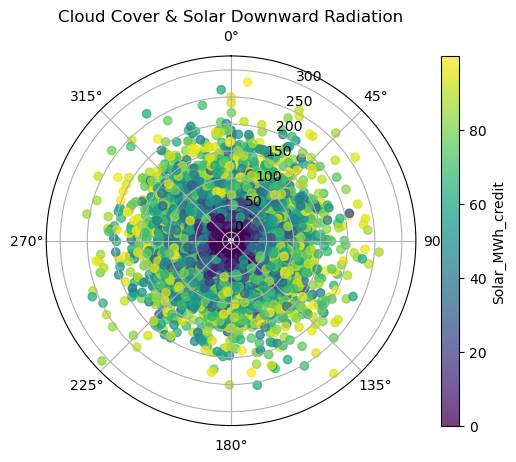

In [ ]:
from matplotlib.colorbar import ColorbarBase
from obspy.imaging.cm import get_cmap
from matplotlib.colors import Normalize

outlier_modeling_table = re_modelling_table[re_modelling_table['Solar_MWh_credit'] <= 100]

cmap = get_cmap('YlGnBu')

# Compute areas and colors

radiance = outlier_modeling_table['SolarDownwardRadiation']
theta = outlier_modeling_table['CloudCover']*360 # <== Note: cloud cover는 0 ~ 1 사이의 값을 가짐.
power = outlier_modeling_table['Solar_MWh_credit']

fig = plt.figure()

ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)

ax.set_title(f'Cloud Cover & Solar Downward Radiation')

c = ax.scatter(theta, radiance, c=power, cmap='viridis', alpha=0.75)

# Colorbar 추가
cbar = fig.colorbar(c)
cbar.set_label('Solar_MWh_credit')

plt.show()

In [6]:
# Final forecasting model input/output data structure.
# final_dataset = re_modelling_table.loc[:,['SolarDownwardRadiation', 'CloudCover', 'Temperature_solar','Solar_MWh_credit']].values

## 평균화
final_dataset = modeling_table.loc[:,['SolarDownwardRadiation', 'CloudCover', 'Temperature_solar','Solar_MWh_credit']].values
## concat
# final_dataset = temp_df_concat_.loc[:,['SolarDownwardRadiation_x', 'SolarDownwardRadiation_y', 'CloudCover_x', 'CloudCover_y', 'Temperature_solar_x', 'Temperature_solar_y', 'Solar_MWh_credit_x']].values


In [ ]:
## data augmentation
aug_ncep_dwd = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data/dwd_ncep_20240121_20240302.csv", index_col=0)
# aug_ncep_dwd = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data/dwd_ncep_concat_20240121_20240302.csv", index_col=0)

aug_solar_energy = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data/solar_energy_data_20240121_20240302.csv", index_col=0)

aug_ncep_dwd_np = aug_ncep_dwd.loc[:,['SolarDownwardRadiation', 'CloudCover', 'Temperature_y']].values
# aug_ncep_dwd_np = aug_ncep_dwd.loc[:,['SolarDownwardRadiation_x', 'SolarDownwardRadiation_y', 'CloudCover_x', 'CloudCover_y', 'Temperature_y_x', 'Temperature_y_y']].values
aug_solar_energy_np = aug_solar_energy.loc[:,['generation_mw']].values

aug_dataset = np.concatenate([aug_ncep_dwd_np,aug_solar_energy_np], axis=1)

## DATA 확장!!!!!!!!!!!!! (~24.03.02)
final_dataset = np.concatenate([final_dataset,aug_dataset], axis=0)

In [7]:
final_dataset.shape

(56832, 4)

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler

# input features
solar_downward = final_dataset[:,0].reshape(-1, 48)
cloud = final_dataset[:,1].reshape(-1, 48)
temp = final_dataset[:,2].reshape(-1, 48)

# solar_downward = final_dataset[:,0].reshape(-1, 48)
# cloud = final_dataset[:,1].reshape(-1, 48)
# temp = final_dataset[:,2].reshape(-1, 48)
# # win_speed = final_dataset[:,3].reshape(-1, 48)
# # win_direction = final_dataset[:,4].reshape(-1, 48)
# pres = final_dataset[:,3].reshape(-1, 48)
# # air_dens = final_dataset[:,3].reshape(-1, 48)
# # abs_humid = final_dataset[:,4].reshape(-1, 48)
# # air_pres = final_dataset[:,7].reshape(-1, 48)
# percip = final_dataset[:,4].reshape(-1, 48)
# # humid = final_dataset[:,4].reshape(-1, 48)
# # air_dens = final_dataset[:,5].reshape(-1, 48)
# # air_pres = final_dataset[:,6].reshape(-1, 48)


# Normalization of each input feature
# windspeed_,_,_ = norm(windspeed)
# solar_downward_,_,_ = norm(solar_downward)
# # winddirection_,_,_ = norm(winddirection)
# humid_,_,_ = norm(humid)
# cloud_,_,_ = norm(cloud)
# temp_,_,_ = norm(temp)

input = np.concatenate([solar_downward, cloud, temp], axis=1)
# input = np.concatenate([solar_downward, cloud, temp, win_speed, win_direction, air_dens], axis=1)

# input = np.concatenate([solar_downward, cloud, temp, pres, percip], axis=1)
# input = np.concatenate([solar_downward, cloud, temp, percip, humid, air_dens, air_pres], axis=1)

# input = np.concatenate([windspeed_, solar_downward_, humid_, cloud_, temp_], axis=1)

# output
# target = final_dataset[:,2].reshape(-1,48)
target = final_dataset[:,3].reshape(-1,48)
# target = final_dataset[:,5].reshape(-1,48)


# split the training/validation/test set
train_len = int(len(input)*0.8)
val_len = int(len(input)*0.1)

#######################################################
# train_input = input[:train_len,:]
# train_output = target[:train_len,:]

# val_input = input[train_len:train_len+val_len,:]
# val_output = target[train_len:train_len+val_len,:]

merge_train_input = input[:train_len+val_len,:]
merge_train_output = target[:train_len+val_len,:]

#######################################################

test_input = input[train_len+val_len:,:]
test_output = target[train_len+val_len:,:]

# Normalization of each dataset
scalerX = MaxAbsScaler() # RobustScaler(quantile_range=(10.0, 90.0))
# scalerX = scalerX.fit(train_input)
scalerX = scalerX.fit(merge_train_input)

# scale
# train_input = scalerX.transform(train_input)
# val_input = scalerX.transform(val_input)

train_input = scalerX.transform(merge_train_input)
test_input = scalerX.transform(test_input)

scalerY = QuantileTransformer(n_quantiles=30, random_state=0, output_distribution="normal") # QuantileTransformer(n_quantiles=30, random_state=0, output_distribution="normal") # MaxAbsScaler() # 
# scalerY = scalerY.fit(train_output)
scalerY = scalerY.fit(merge_train_output)

# scale
# train_output = scalerY.transform(train_output)
# val_output = scalerY.transform(val_output)

train_output = scalerY.transform(merge_train_output)
test_output = scalerY.transform(test_output)

###############################################
# train_input_ = train_input
# train_output_ = train_output
# val_input_ = val_input
# val_output_ = val_output

train_input_ = train_input
train_output_ = train_output
###############################################

test_input_ = test_input
test_output_ = test_output

## Test phase: 거의 실제 모델 성능 check!

In [7]:
dwd_test_weather = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\dwd_icon_eu_weather_forecast_for_wind_solar_20240518_0.csv", index_col=0)
# dwd_test_weather = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\data_for_solar_forecast_20200920_20240118.csv", index_col=0)
# dwd_test_weather = dwd_test_weather.iloc[-912:,:]


# dwd_test_weather = dwd_test_weather[(dwd_test_weather['valid_datetime'] >= '2024-04-11 23:00:00') & (dwd_test_weather['valid_datetime'] < '2024-04-12 23:00:00')] # UTC
dwd_test_weather = dwd_test_weather[(dwd_test_weather['valid_datetime'] >= '2024-05-18 22:00:00') & (dwd_test_weather['valid_datetime'] < '2024-05-19 22:00:00')] # London time

dwd_test_weather['valid_datetime'] = pd.to_datetime(dwd_test_weather['valid_datetime'])
dwd_test_weather['ref_datetime'] = pd.to_datetime(dwd_test_weather['ref_datetime'])

# pressure_in_london = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\PV_Pressure_for_temp_test.csv", encoding='cp949')
# pressure_in_london["Sea Level Pressure"] = pressure_in_london["Sea Level Pressure"]/100
# pressure_in_london['Valid Time'] = pd.to_datetime(pressure_in_london['Valid Time'])
# pressure_in_london = pressure_in_london[["Valid Time", "Sea Level Pressure"]]
# year_6h = pd.DataFrame(pd.date_range(start="2024-01-01", end="2024-01-09", freq="6h")).iloc[:-1]
# year_6h.columns = ['year_6h']
# pressure_in_london = year_6h.merge(pressure_in_london, how="outer", 
#                                       left_on="year_6h", 
#                                       right_on="Valid Time")

# pressure_in_london['6h'] = pressure_in_london['year_6h'].dt.hour
# fill_mean_func = lambda g: g.fillna(g.mean())
# pressure_in_london = pressure_in_london.groupby('6h').apply(fill_mean_func).reset_index(drop=True).sort_values('year_6h')[['year_6h', 'Sea Level Pressure']]

# dict_pressure_in_london = {str(datetime)[:] : pressure for datetime, pressure in pressure_in_london.values}


# percipitation_in_london = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\PV_percipitation_for_temp_test.csv", encoding='cp949')
# percipitation_in_london['Valid Time'] = pd.to_datetime(percipitation_in_london['Valid Time'])
# percipitation_in_london = percipitation_in_london[["Valid Time", "Total precipitation"]]
# year_day = pd.DataFrame(pd.date_range(start="2024-01-01", end="2024-01-09", freq="D")).iloc[:-1]
# year_day.columns = ['year_day']
# percipitation_in_london = year_day.merge(percipitation_in_london, how="outer", 
#                                       left_on="year_day", 
#                                       right_on="Valid Time")

# percipitation_in_london['day'] = percipitation_in_london['year_day'].dt.day
# fill_mean_func = lambda g: g.fillna(g.mean())
# percipitation_in_london = percipitation_in_london.groupby('day').apply(fill_mean_func).reset_index(drop=True).sort_values('year_day')[['year_day', 'Total precipitation']]

# dict_percipitation_in_london = {str(datetime)[:] : percipitation for datetime, percipitation in percipitation_in_london.values}


# def get_pressure(datetime):
#     month = datetime.month
#     day = datetime.day
#     hour = datetime.hour
#     minute = datetime.minute
#     if hour == 0 and minute==0:
#         return dict_pressure_in_london[str(datetime)[:10]+" 00:00:00"]
#     if hour == 6 and minute==0:
#         return dict_pressure_in_london[str(datetime)[:10]+" 06:00:00"]
#     if hour == 12 and minute==0:
#         return dict_pressure_in_london[str(datetime)[:10]+" 12:00:00"]
#     if hour == 18 and minute==0:
#         return dict_pressure_in_london[str(datetime)[:10]+" 18:00:00"]
#     # special case.
#     if month == 1 and day == 7 and hour == 23 and minute==0:
#         datetime_ = datetime - timedelta(days=1)
#         return dict_pressure_in_london[str(datetime_)[:10]+" 18:00:00"]
    
# dwd_test_weather['percipitation'] = dwd_test_weather.apply(lambda x : get_percipitation(x['valid_datetime']), axis=1).interpolate('linear')
# dwd_test_weather['pressure'] = dwd_test_weather.apply(lambda x : get_pressure(x['valid_datetime']), axis=1).interpolate('linear')

weather_input = dwd_test_weather.loc[:,['SolarDownwardRadiation', 'CloudCover', 'Temperature_y']].values
# weather_input = dwd_test_weather.loc[:,['SolarDownwardRadiation', 'CloudCover', 'Temperature_solar']].values

# weather_input = dwd_test_weather.loc[:,['SolarDownwardRadiation', 'CloudCover', 'Temperature_y', 'pressure', 'percipitation']].values

# weather_input = dwd_test_weather.loc[:,['SolarDownwardRadiation', 'CloudCover', 'Temperature_y','PressureReducedMSL_y','TotalPrecipitation_y']].values


# pv_test = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\solar_mv_2024-01-05.csv",index_col=0).iloc[:-1,:]

# target_output = 0.5*pv_test.loc[:,['generation_mw']].values.T

In [8]:
ncep_test_weather = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\ncep_gfs_weather_forecast_for_wind_solar_20240518_0.csv", index_col=0)

# ncep_test_weather = ncep_test_weather[(ncep_test_weather['valid_datetime'] >= '2024-04-11 23:00:00') & (ncep_test_weather['valid_datetime'] < '2024-04-12 23:00:00')]
ncep_test_weather = ncep_test_weather[(ncep_test_weather['valid_datetime'] >= '2024-05-18 22:00:00') & (ncep_test_weather['valid_datetime'] < '2024-05-19 22:00:00')]
ncep_test_weather['valid_datetime'] = pd.DatetimeIndex(ncep_test_weather['valid_datetime'])
ncep_test_weather['ref_datetime'] = pd.to_datetime(ncep_test_weather['ref_datetime'])

weather_input_ncep = ncep_test_weather.loc[:,['SolarDownwardRadiation', 'CloudCover', 'Temperature_y']].values

* 평균화

In [10]:
# 두 데이터프레임을 연결하여 하나의 데이터프레임으로 합침
test_weather_merged_df = pd.concat([dwd_test_weather, ncep_test_weather], axis=0)

test_weather_merged_df = test_weather_merged_df.reset_index().groupby(['ref_datetime', 'valid_datetime']).mean().reset_index()
weather_input = test_weather_merged_df.loc[:,['SolarDownwardRadiation', 'CloudCover', 'Temperature_y']].values

* Concat

In [99]:
# # 두 데이터프레임을 연결하여 하나의 데이터프레임으로 합침
# dwd_test_weather.columns = ['valid_datetime', 'ref_datetime', 'PressureReducedMSL_x', 'RelativeHumidity_x', 'Temperature_x', 'TotalPrecipitation_x', 'WindDirection_x', 'WindDirection:100_x', 
#                             'WindSpeed_x', 'WindSpeed:100_x', 'SolarDownwardRadiation_x', 'TotalPrecipitation_y_x', 'CloudCover_x', 'Temperature_y_x', 'PressureReducedMSL_y_x',]
# ncep_test_weather.columns = ['valid_datetime', 'ref_datetime', 'PressureReducedMSL_y', 'RelativeHumidity_y', 'Temperature_y', 'TotalPrecipitation_y', 'WindDirection_y', 'WindDirection:100_y', 
#                             'WindSpeed_y', 'WindSpeed:100_y', 'SolarDownwardRadiation_y', 'TotalPrecipitation_y_y', 'CloudCover_y', 'Temperature_y_y', 'PressureReducedMSL_y_y']
# test_weather_merged_df = pd.concat([dwd_test_weather, ncep_test_weather], axis=1)

# weather_input = test_weather_merged_df.loc[:,['SolarDownwardRadiation_x', 'SolarDownwardRadiation_y', 'CloudCover_x', 'CloudCover_y', 'Temperature_y_x', 'Temperature_y_y']].values

In [21]:
weather_input = weather_input_ncep
weather_input.shape

# target_output.shape
# pv_test

(48, 3)

* 이전의 train, test 다 합치기

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler

# input features
solar_downward = final_dataset[:,0].reshape(-1, 48)
cloud = final_dataset[:,1].reshape(-1, 48)
temp = final_dataset[:,2].reshape(-1, 48)

# solar_downward_x = final_dataset[:,0].reshape(-1, 48)
# solar_downward_y = final_dataset[:,1].reshape(-1, 48)
# cloud_x = final_dataset[:,2].reshape(-1, 48)
# cloud_y = final_dataset[:,3].reshape(-1, 48)
# temp_x = final_dataset[:,4].reshape(-1, 48)
# temp_y = final_dataset[:,5].reshape(-1, 48)



input = np.concatenate([solar_downward, cloud, temp], axis=1)
# input = np.concatenate([solar_downward_x, solar_downward_y, cloud_x, cloud_y, temp_x, temp_y], axis=1)

# input = np.concatenate([solar_downward, cloud, temp, pres, percip], axis=1)

target = final_dataset[:,3].reshape(-1,48)
# target = final_dataset[:,6].reshape(-1,48)


# Normalization of each dataset
scalerX = MaxAbsScaler() # RobustScaler(quantile_range=(10.0, 90.0))
# scalerX = scalerX.fit(train_input)
scalerX = scalerX.fit(input)

# scale
# train_input = scalerX.transform(train_input)
# val_input = scalerX.transform(val_input)

train_input = scalerX.transform(input)

scalerY = QuantileTransformer(n_quantiles=30, random_state=0, output_distribution="normal") # QuantileTransformer(n_quantiles=30, random_state=0, output_distribution="normal") # MaxAbsScaler() # 
# scalerY = scalerY.fit(train_output)
scalerY = scalerY.fit(target)

# scale
# train_output = scalerY.transform(train_output)
# val_output = scalerY.transform(val_output)

train_output = scalerY.transform(target)

###############################################
# train_input_ = train_input
# train_output_ = train_output
# val_input_ = val_input
# val_output_ = val_output

train_input_ = train_input
train_output_ = train_output

* test input 처리

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler

# input features
solar_downward_ = weather_input[:,0].reshape(-1, 48)
cloud_ = weather_input[:,1].reshape(-1, 48)
temp_ = weather_input[:,2].reshape(-1, 48)

# solar_downward_x = weather_input[:,0].reshape(-1, 48)
# solar_downward_y = weather_input[:,1].reshape(-1, 48)
# cloud_x = weather_input[:,2].reshape(-1, 48)
# cloud_y = weather_input[:,3].reshape(-1, 48)
# temp_x = weather_input[:,4].reshape(-1, 48)
# temp_y = weather_input[:,5].reshape(-1, 48)


input_ = np.concatenate([solar_downward_, cloud_, temp_], axis=1)
# input_ = np.concatenate([solar_downward_x, solar_downward_y, cloud_x, cloud_y, temp_x, temp_y], axis=1)


# output
# test_target = target_output


# Normalization of each dataset
# scalerX = MaxAbsScaler() # RobustScaler(quantile_range=(10.0, 90.0))
# scalerX = scalerX.fit(train_input)
# scalerX = scalerX.fit(input)

input_ = scalerX.transform(input_)

In [12]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, IterableDataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.xdomain = x_tensor
        self.ydomain = y_tensor
        
    def __getitem__(self, index):
        return (self.xdomain[index], self.ydomain[index])
    
    def __len__(self):
        return len(self.xdomain)

In [14]:
# batch_size = 128 # 32: QLSTM, 128: QTransLSTM

# train_dataset = CustomDataset(torch.tensor(train_input_, dtype=torch.float), torch.tensor(train_output_, dtype=torch.float))
# val_dataset = CustomDataset(torch.tensor(val_input_, dtype=torch.float), torch.tensor(val_output_, dtype=torch.float))
# test_dataset = CustomDataset(torch.tensor(test_input_, dtype=torch.float), torch.tensor(test_output_, dtype=torch.float))


# train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
# val_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [13]:
## (Huber) Quantile loss 
def QuantileLoss(preds, target, quantiles):
  assert not target.requires_grad
  assert preds.size(0) == target.size(0)
  losses = []
  for i, q in enumerate(quantiles):
    # errors = target - preds[:, i]
    # errors = target - preds[:, i*48:(i+1)*48]
    errors = target - preds[:, i, :]

    # # # huber loss
    # zero_error = torch.zeros_like(errors)
    # sq = torch.maximum(-errors, torch.zeros_like(errors))
    # s1_q = torch.maximum(errors, torch.zeros_like(errors))    
    # h_loss = F.huber_loss(q*sq, zero_error, reduction='none', delta=1.0) + F.huber_loss((1-q)*s1_q, zero_error, reduction='none', delta=1.0)
    # losses.append(h_loss.unsqueeze(1))
    
    losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))

    # if i == 0:
    #   losses = torch.max((q-1)*errors, q*errors).unsqueeze(1)
    #   # losses = torch.max((q-1)*errors, q*errors).reshape(1)
    # else:
    #   losses = torch.cat((losses, torch.max((q-1)*errors, q*errors).unsqueeze(1)))
    #   # losses = torch.cat((losses, torch.max((q-1) * errors, q * errors).reshape(1)))
  
  # loss = torch.mean(torch.sum(losses, dim = 1)) 
  loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1)) 
  
  # loss = torch.mean(losses)
  return loss

In [14]:
def pinball(y,q,alpha):
    return (y-q)*alpha*(y>=q) + (q-y)*(1-alpha)*(y<q)

def pinball_score(true, pred):
    score = list()
    for qu in range(10,100,10):
        score.append(pinball(y=true,
            # q=pred[:,48*(int(qu*0.1)-1):48*(int(qu*0.1))],
            q=pred[:,int(qu*0.1)-1,:],
            alpha=qu/100).mean())
    return sum(score)/len(score)

## Q-LNN model

In [109]:
# < DWD Weather forecast model : SAM optimizer >
# train_batch_size: 128
# epoch: 700
# lr: 0.0013474257676472676
# rho: 0.06671972418857779
# adaptive: False
# optimizer: <class 'torch.optim.adamw.AdamW'>
# ltc_hidden_size: 128
# ode_unfolds: 4
# linear_hidden_size: 256
# dropout: 0.6909832886889813

In [110]:
# < DWD Weather forecast model : GSAM optimizer >
# {'train_batch_size': 32, 
#  'epoch': 800, 
#  'lr': 0.0058440375305032904, 
#  'adaptive': False, 
#  'lr_scheduler_max': 0.0033916845120241365, 
#  'lr_scheduler_min': 4.1568268118667546e-05, 
#  'rho_scheduler_max': 0.48613589755696807, 
#  'rho_scheduler_min': 0.011170681358615741, 
#  'gsam_alpha': 0.06711309899661547, 
#  'optimizer': <class 'torch.optim.adamw.AdamW'>, 
#  'ltc_hidden_size': 32, 
#  'ode_unfolds': 3, 
#  'linear_hidden_size': 128, 
#  'dropout': 0.6835974144017176}

In [15]:
input_size = 48*3 # 48*3, 48*6
hidden_size = 128
hidden_size_1 = 256 

output_size = 48 # half-hour of the day-ahead forecasting.
learning_rate = 0.0013474257676472676

quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
device = "cuda" if torch.cuda.is_available() else "cpu"

class LNN(nn.Module):
    def __init__(self, quantile_list, feature_size = input_size): # 1
        super(LNN, self).__init__()
        # self.quantile_list = quantile_list
        self.n_quantiles = len(quantile_list)
        # self.decoder_rnn = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=4, batch_first=True, dropout=0.7806420352385486) #dropout=0.5
        self.decoder_rnn = LTC(feature_size, hidden_size, batch_first=True, mixed_memory=True, ode_unfolds=4) 
        
        # self.decoder_fc_h1 = nn.Linear(hidden_size*4, hidden_size_1)
        self.decoder_fc_h1 = nn.Linear(hidden_size, hidden_size_1)
        
        # torch.nn.init.xavier_uniform_(self.decoder_fc_h1.weight)
        torch.nn.init.xavier_normal_(self.decoder_fc_h1.weight)

        # initialize LSTM forget gate bias to be 1 as recommanded by http://proceedings.mlr.press/v37/jozefowicz15.pdf
        # for names in self.decoder_rnn._all_weights:
        #     for name in filter(lambda n: "bias" in n, names):
        #         bias = getattr(self.decoder_rnn, name)
        #         n = bias.size(0)
        #         start, end = n // 4, n // 2
        #         bias.data[start:end].fill_(0.)

        # for weight in self.decoder_rnn._all_weights:
        #     if "weight" in weight:
        #         nn.init.xavier_normal_(getattr(self.decoder_rnn, weight))
        #     if "bias" in weight:
        #         nn.init.normal_(getattr(self.decoder_rnn, weight))
        
        ## Quantile regression part 
        self.linear_quantiles = nn.ModuleList([nn.Linear(hidden_size_1, output_size) 
                                        for q_idx in range(self.n_quantiles)])

        # Initialize the quantile regression layer
        for q in self.linear_quantiles:
            q.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x = x.reshape(-1,1,48*3) # (batch, seq, feat)
        
        # _, (hidden, cell) = self.decoder_rnn(x)
        # hidden_permute = hidden.permute(1, 2, 0).contiguous().view(hidden.shape[1], -1)

        _, (hidden, cell) = self.decoder_rnn(x)
        hidden = hidden.unsqueeze(0)
        hidden_permute = hidden.permute(1, 2, 0).contiguous().view(hidden.shape[1], -1)
        
        x = F.relu(self.decoder_fc_h1(hidden_permute))

        x = F.dropout(x, p=0.5, training=self.training)
        for q_idx, q_linear in enumerate(self.linear_quantiles):
            # q_output = q_linear(x)
            q_output = torch.unsqueeze(q_linear(x), dim=1)
            if q_idx == 0:
                q_result = q_output
            else:
                q_result = torch.cat((q_result, q_output), dim = 1) # dim에 따라 nn의 output 형태가 달라짐!

        # return F.relu(q_result)
        return q_result
    
        
# def train_net(model, batch, optimizer, quantile_list, lr_scheduler):
def train_net(model, batch, optimizer, quantile_list):
    x, y = batch[0], batch[1]
    yhat = model.forward(x)
    
    # loss = QuantileLoss(yhat, y, quantile_list)
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    # using SAM
    # first forward-backward step
    loss = QuantileLoss(yhat, y, quantile_list)
    loss.backward()
    optimizer.first_step(zero_grad=True)

    # second forward-backward step
    QuantileLoss(model.forward(x), y, quantile_list).backward()
    optimizer.second_step(zero_grad=True)

    # using GSAM
    # optimizer.set_closure(QuantileLoss, x, y, quantile_list)
    # predictions, loss = optimizer.step()
    
    # lr_scheduler.step()
    # optimizer.update_rho_t()
    
    return loss.item() # training loss

# Training models

In [44]:
train_input_.shape
train_output_.shape

(1235, 48)

In [45]:
# Do when the hyperparameter tuning is done.
batch_size = 128 # 256: QLNN, 64: QLSTM

# merge_train_input_ = np.concatenate([train_input_, val_input_], axis=0)
# merge_train_output_ = np.concatenate([train_output_, val_output_], axis=0)
# train_dataset = CustomDataset(torch.tensor(merge_train_input_, dtype=torch.float), torch.tensor(merge_train_output_, dtype=torch.float))

train_dataset = CustomDataset(torch.tensor(train_input_, dtype=torch.float), torch.tensor(train_output_, dtype=torch.float))

## For TCN case
# train_dataset = CustomDataset(torch.tensor(merge_train_input_, dtype=torch.float).unsqueeze(1), torch.tensor(merge_train_output_, dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=False)

In [46]:
RANDOM_SEED = 0 # 21
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
set_seed()

total_epoch    = 700 # 850, 900, 
print_interval = 50

model = LNN(quantile_list).to(device)
# model = QLSTM(quantile_list).to(device)

# input_size = 1 # channel size: (N, C, L) = (batch, 1, 48*5) 
# output_size = 48 # half-hour of the day-ahead forecasting.
# num_channels = [256]*4 # hidden_size * # levels(i.e., layers)
# kernel_size = 32 
# dropout = 0.5
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
# model = TCN(input_size=input_size, output_size=output_size, num_channels=num_channels, kernel_size=kernel_size, dropout=dropout, quantile_list=quantile_list).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

# using SAM
base_optimizer = torch.optim.AdamW # RAdam, AdamW, Adamax
# optimizer = SAM(model.parameters(), base_optimizer, lr=0.01, momentum=0.9, adaptive=False) # SGD
optimizer = SAM(model.parameters(), base_optimizer, rho=0.067, lr=0.0014, adaptive=False) # weight_decay=1e-1

# using GSAM
# base_optimizer = torch.optim.AdamW(model.parameters(), lr=0.0058440375305032904)
# # base_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# lr_scheduler = LinearScheduler(T_max=total_epoch*train_dataset.__len__(), max_value=0.0033916845120241365, min_value=4.1568268118667546e-05, optimizer=base_optimizer)
# rho_scheduler = LinearScheduler(T_max=total_epoch*train_dataset.__len__(), max_value=0.48613589755696807, min_value=0.011170681358615741)
# optimizer = GSAM(params=model.parameters(), base_optimizer=base_optimizer, model=model, gsam_alpha=0.06711309899661547, rho_scheduler=rho_scheduler, adaptive=False) 

# early stopping
best_loss = 99999
PATH = r'D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\models/'

val_predict = []
pinball_val = []

train_loss = []
for epoch in range(total_epoch):
    train_batch_loss = []
    for batch in train_loader:
        model.train()
        batch = [batch[0].to(device), batch[1].to(device)]
        # print(batch[1].shape)
        
        train_batch_loss += [train_net(model, batch, optimizer, quantile_list)]
        # train_batch_loss += [train_net(model, batch, optimizer, quantile_list, lr_scheduler)]
        

    train_loss += [np.mean(train_batch_loss)]

    if epoch == 0 or (epoch+1) % print_interval == 0:
        # val_predict += [model.forward(torch.tensor(val_input_, dtype=torch.float).to(device)).cpu().data.detach().numpy()]
        # # test_predict  += [model.forward(torch.tensor(input_val_data, dtype=torch.float).to(device)).cpu().data.detach().numpy()]   # Validation data로 바꿔줘야 함!
        
        # pinball_val += [round(pinball_score(val_output_, val_predict[-1]),5)]
        # # NMAE_test += [round(100*np.sum(single_val_object*np.abs(pv_val_output - test_predict[-1]))/np.sum(single_val_object),2)]

        # Early Stopping & save model
        # if NMAE_test[-1] < best_loss:
        #     print(f"Best performance at epoch: {epoch + 1}")
        #     print(f"Save model in {PATH}")
        #     best_loss = NMAE_test[-1]
            # torch.save(model_single, PATH + vpp_names[5] + '_TransGRU_atten_visual.pt')

        print("epoch: {}".format(epoch+1).ljust(25), end="")
        print("q_loss_train: {}".format(train_loss[-1]).ljust(25))
        # print("pinball_val: {}".format(pinball_val[-1]).ljust(25))

alloc!
epoch: 1                 q_loss_train: 12.333436203002929
epoch: 50                q_loss_train: 3.053052043914795
epoch: 100               q_loss_train: 2.4860678195953367
epoch: 150               q_loss_train: 2.14981324672699
epoch: 200               q_loss_train: 2.006284403800964
epoch: 250               q_loss_train: 1.9465243339538574
epoch: 300               q_loss_train: 1.8669989824295044
epoch: 350               q_loss_train: 1.8223048090934753
epoch: 400               q_loss_train: 1.7756427645683288
epoch: 450               q_loss_train: 1.6972659468650817
epoch: 500               q_loss_train: 1.6659022569656372
epoch: 550               q_loss_train: 1.6136220335960387
epoch: 600               q_loss_train: 1.5700108885765076
epoch: 650               q_loss_train: 1.5024675369262694
epoch: 700               q_loss_train: 1.4675701379776


# Test models

In [23]:
# test_input_.shape
# target_output.shape
input_.shape
input_[:,:48]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.09064264, 0.14960052,
        0.279971  , 0.37510787, 0.47413969, 0.55515178, 0.63373408,
        0.70290083, 0.76791459, 0.82848105, 0.89158474, 0.94906199,
        0.96327043, 0.95287401, 0.97647145, 1.01137655, 1.06664744,
        1.11010344, 1.12781041, 1.14767421, 1.16843952, 1.19342719,
        1.21883483, 1.22101459, 1.22580238, 1.23257892, 1.30020724,
        1.43423084, 1.03689732, 0.5610959 , 0.28071413, 0.        ,
        0.        , 0.        , 0.        ]])

In [17]:
# ## Model 불러오기
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_feature_engine_w_combination_test_extend_X.pt")
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_X.pt")
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_X_noise_remove.pt")
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove.pt")
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove(ver2_test).pt")
#################################### IGNORE ###########################################


# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove(ver3_test).pt") # ~23.10.27 (dwd)
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove_ncep_dwd(ver3_test).pt") # ~23.10.27 (ncep+dwd)
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove_ncep_dwd(ver3_test_re).pt") # ~23.12.30 (ncep+dwd)
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove_ncep_dwd(ver4_test).pt") # ~24.03.02 (ncep+dwd)
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove_ncep_dwd_concat(ver4).pt") # ~24.03.02 (ncep+dwd; concat)

# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove_ncep_dwd_weather_non_stationary.pt") # ~23.12.30 (ncep+dwd)
model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove_ncep_dwd_weather_non_stationary_london_time.pt") # ~23.12.30 (ncep+dwd), london time
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove_ncep_dwd_weather_non_stationary_london_time_aug.pt") # ~23.12.30 (ncep+dwd), london time, data augmentation

In [24]:
with torch.no_grad():
    model.eval()
    # # test output
    # test_pred = model.forward(torch.tensor(test_input_, dtype=torch.float).to(device)).cpu().data.detach().numpy()
    # test output
    test_pred = model.forward(torch.tensor(input_, dtype=torch.float).to(device)).cpu().data.detach().numpy()


# inv_test_pred = rev_min_max_func(test_pred, test_max, test_min)

inv_test_pred = np.zeros(test_pred.shape)
# inv_test_pred = np.zeros(prediction_int.shape) # for RF

for q in range(len(quantile_list)):
    # inv_test_pred[:,48*q:48*(q+1)] = scalerY.inverse_transform(test_pred[:,48*q:48*(q+1)])
    inv_test_pred[:,q,:] = scalerY.inverse_transform(test_pred[:,q,:])
    # inv_test_pred[:,q,:] = scalerY.inverse_transform(prediction_int[:,q,:]) # for RF
    
# inv_test_output = scalerY.inverse_transform(test_output_)
# # inv_test_output = target_output

# # Pinball score
# pinball_test = round(pinball_score(inv_test_output[:,:], inv_test_pred[:,:]),5)

# # pinball_test_ = round(pinball_score(inv_test_output[3:4,:], inv_test_pred[3:4,:]),5)
# pinball_test_ = round(pinball_score(inv_test_output[15:16,:], inv_test_pred[15:16,:,:]),5)


# print("(Total) Pinball test: {}".format(pinball_test).ljust(25))
# print("(Partial) Pinball test: {}".format(pinball_test_).ljust(25))

In [47]:
# torch.save(model, r'C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_feature_engine_w_combination_test_extend_X.pt')
# torch.save(model, r'C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_pv_extend_O_noise_remove_ncep_dwd_weather_non_stationary.pt')

In [25]:
inv_test_pred[0,4,:]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.08547249e+01, 6.14688339e+01,
       8.80567474e+01, 1.47357422e+02, 2.57287659e+02, 3.58872620e+02,
       4.78114960e+02, 5.77922852e+02, 6.68759583e+02, 7.20057495e+02,
       7.60857727e+02, 7.76785461e+02, 7.88652954e+02, 7.97305176e+02,
       7.93762817e+02, 7.84079468e+02, 7.81840820e+02, 7.73032715e+02,
       7.12225159e+02, 6.49667175e+02, 5.52630981e+02, 4.36565063e+02,
       3.47088562e+02, 2.38103943e+02, 1.98482925e+02, 1.87658203e+02,
       1.10084984e+02, 6.04669952e+01, 3.78269074e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [26]:
# inv_test_pred
# np.save(r'C:\Users\kjson\Desktop\IEEE_Forecasting_competition\LNN_solar_predict_result.npy', inv_test_pred)

np.save(r'C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\dwd_ncep_merge_case\LNN_solar_predict_result_05_19_extend_O_ncep.npy', inv_test_pred)


# np.save(r'C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\dwd_ncep_merge_case\test\LNN_solar_predict_result_04_07_extend_O_ncep_aug.npy', inv_test_pred)
# np.save(r'C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\LNN_solar_predict_result_03_05_extend_O_2.npy', inv_test_pred)


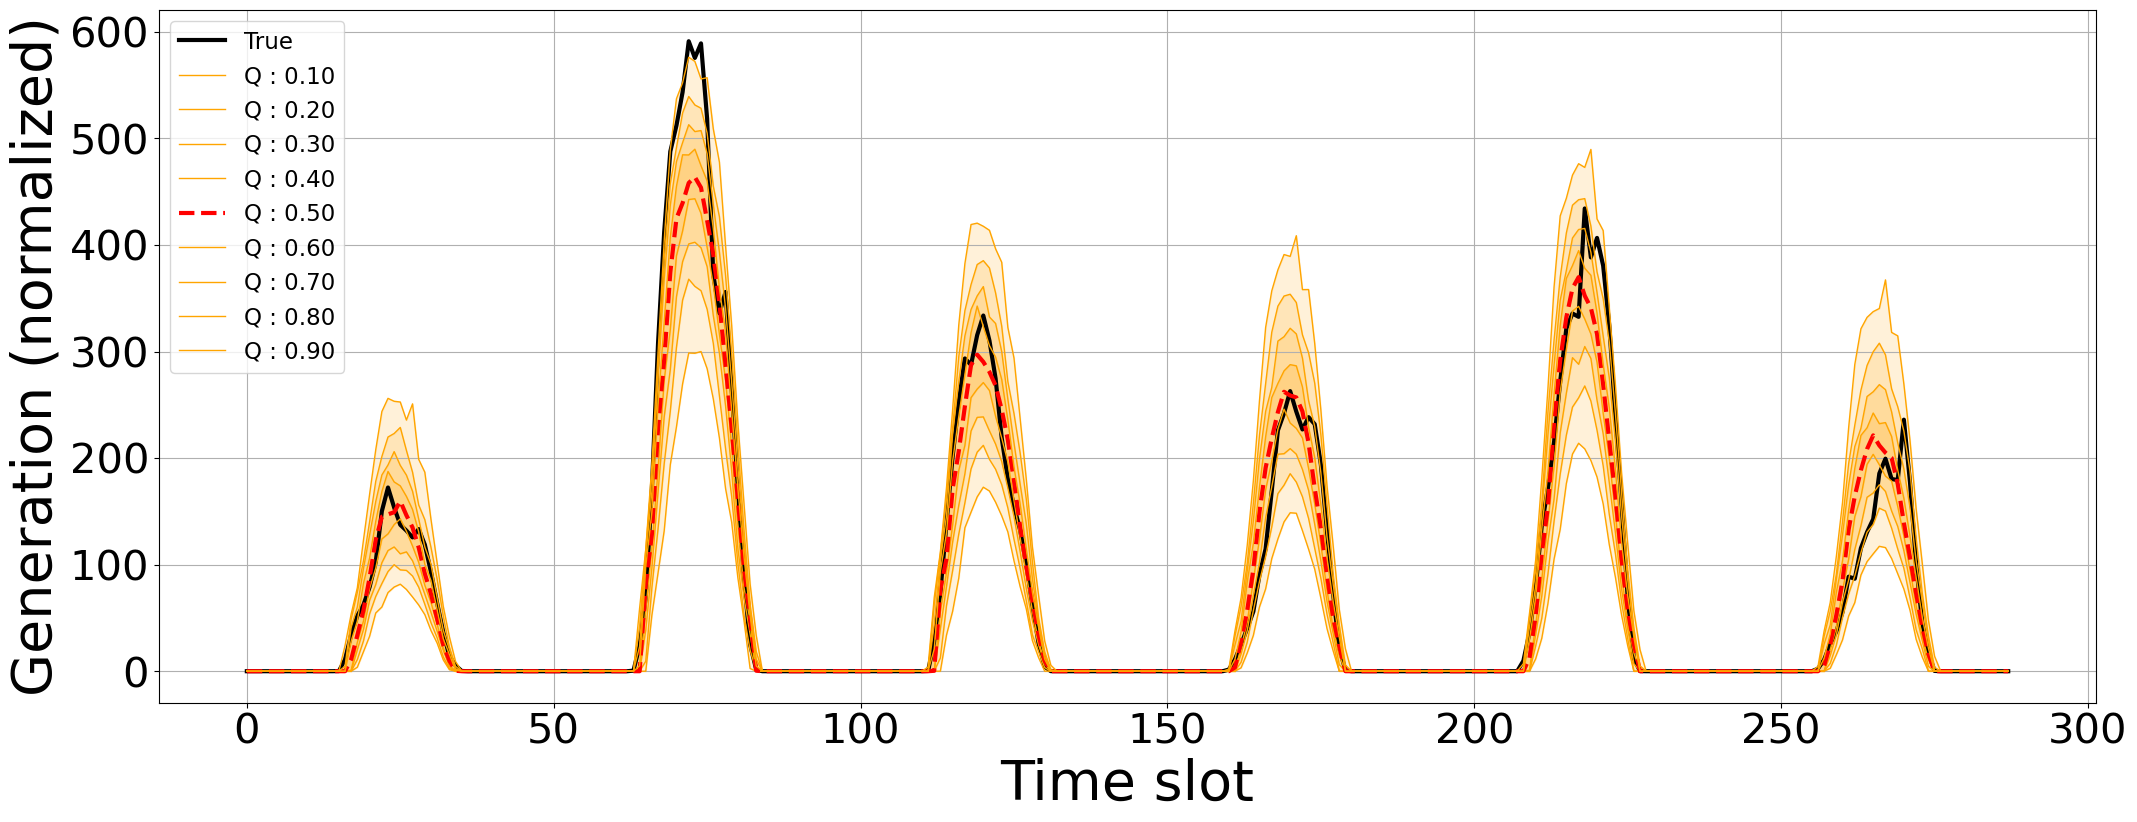

In [212]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(25,9))

## day 설정
start = -7 # None
end = -1 # None

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_quantiles = len(quantiles)

test_y_normalized_inv = inv_test_output[start:end,:]
test_pred_ = inv_test_pred

ax.plot(test_y_normalized_inv.reshape(-1), label='True', color = 'black', linewidth = 3)

# 0.5 pred
# ax.plot(test_pred[start:end,24*4:24*(4+1)].reshape(-1), label = 'pred', color = 'red', linewidth =3)

# # 0.1, 0.9
# ax.fill_between(np.arange((end - start)*24), test_pred[start:end,24*0:24*1].reshape(-1), test_pred[start:end,24*8:24*9].reshape(-1), color = 'orange', alpha = 0.7, label='90%')
# # 0.2, 0.8
# ax.fill_between(np.arange((end - start)*24), test_pred[start:end,24*1:24*2].reshape(-1), test_pred[start:end,24*7:24*8].reshape(-1), color = 'red', alpha = 0.3, label='80%')


# 0.1, 0.9
ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,0,:].reshape(-1), test_pred_[start:end,-1,:].reshape(-1), color = 'orange', alpha = 0.15)
# ax.fill_between(np.arange(48), test_pred_[start:end,0,:].reshape(-1), test_pred_[start:end,-1,:].reshape(-1), color = 'orange', alpha = 0.15)

# 0.2, 0.8
ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,1,:].reshape(-1), test_pred_[start:end,-2,:].reshape(-1), color = 'orange', alpha = 0.15)
# ax.fill_between(np.arange(48), test_pred_[start:end,1,:].reshape(-1), test_pred_[start:end,-2,:].reshape(-1), color = 'orange', alpha = 0.15)

# 0.3, 0.7
ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,2,:].reshape(-1), test_pred_[start:end,-3,:].reshape(-1), color = 'orange', alpha = 0.15)
# ax.fill_between(np.arange(48), test_pred_[start:end,2,:].reshape(-1), test_pred_[start:end,-3,:].reshape(-1), color = 'orange', alpha = 0.15)

# 0.4, 0.6
ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,3,:].reshape(-1), test_pred_[start:end,-4,:].reshape(-1), color = 'orange', alpha = 0.15)
# ax.fill_between(np.arange(48), test_pred_[start:end,3,:].reshape(-1), test_pred_[start:end,-4,:].reshape(-1), color = 'orange', alpha = 0.15)

# # 0.1, 0.9
# ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,48*0:48*1].reshape(-1), test_pred_[start:end,48*8:48*9].reshape(-1), color = 'orange', alpha = 0.15)
# # 0.2, 0.8
# ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,48*1:48*2].reshape(-1), test_pred_[start:end,48*7:48*8].reshape(-1), color = 'orange', alpha = 0.15)
# # 0.3, 0.7
# ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,48*2:48*3].reshape(-1), test_pred_[start:end,48*6:48*7].reshape(-1), color = 'orange', alpha = 0.15)
# # 0.4, 0.6
# ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,48*3:48*4].reshape(-1), test_pred_[start:end,48*5:48*6].reshape(-1), color = 'orange', alpha = 0.15)


for q_idx in range(n_quantiles):
    if quantiles[q_idx] == 0.5:
      quantile_color = 'red'
      quantile_linestyle = '--'
      quantile_linewidth = 3
      alpha = 1
    else:
      quantile_color = 'orange'
      quantile_linestyle = 'solid'
      quantile_linewidth = 1
      alpha = 1

    # ax.plot(test_pred_[start:end,48*q_idx:48*(q_idx+1)].reshape(-1), label = ('Q : %.2f' %quantiles[q_idx]), color = quantile_color, linestyle = quantile_linestyle, linewidth = quantile_linewidth, alpha=alpha)
    ax.plot(test_pred_[start:end,q_idx,:].reshape(-1), label = ('Q : %.2f' %quantiles[q_idx]), color = quantile_color, linestyle = quantile_linestyle, linewidth = quantile_linewidth, alpha=alpha)
    

plt.grid()
# ax.set(title="Test set : PV power forecasting", ylabel="Normalized Power", xlabel="Time")

# plt.title("Test set : PV power forecasting", fontsize=20)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel('Time slot', fontsize=40)
plt.ylabel('Generation (normalized)', fontsize=40)

legend = ax.legend(loc='upper left',fontsize=20, frameon=1, prop={'size': 16.5})
plt.show()